In [19]:
from torch_DE.geometry.shapes import *
from torch_DE.continuous import DE_Getter
from torch_DE.continuous.Networks import MLP,Fourier_Net
from torch_DE.utils import *
from torch_DE.continuous.Engines import FD_engine

from torch_DE.equations import get_NavierStokes
from torch.optim.lr_scheduler import StepLR
from torch_DE.post import Plotter

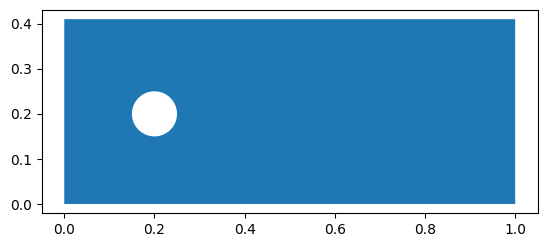

In [2]:
from torch_DE.geometry.shapes import Circle,Rectangle,Domain2D
(xmin,xmax),(ymin,ymax) = (0,1), (0,0.41)
domain = Rectangle(((xmin,ymin),(xmax,ymax) ),'corners')
domain = Domain2D(base = domain)

hole = Circle((0.2,0.2),r = 0.05,num_points= 512)
domain.remove(hole,names= ['Cylinder'])

domain.plot()

In [5]:
sdf = domain.create_sdf(resolution = 256,device='cuda')

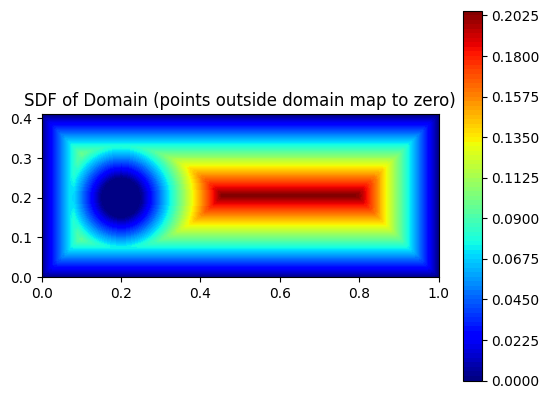

In [6]:
domain.plot_sdf()

In [7]:
sampled_points = domain.generate_points(400_000)

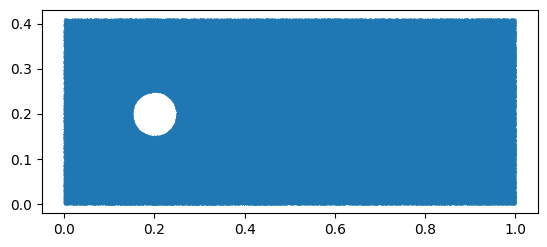

In [6]:
plt.gca().set_aspect('equal')
plt.scatter(sampled_points[:,0],sampled_points[:,1],s=0.1)

In [12]:
domain.add_boundary_group('Cylinder','curve','Cyl_No_Slip')

num_points = 150
boundary_points = domain.generate_boundary_points(num_points=num_points,random = False)

inlet = boundary_points['exterior_edge_0']
top_wall = boundary_points['exterior_edge_1']
outlet = boundary_points['exterior_edge_2']
bot_wall = boundary_points['exterior_edge_3']

cyl = boundary_points['Cyl_No_Slip']


C:\Users\John Su\Downloads\Py_DE\Pytorch_PINNs\src\torch_DE\geometry\shapes.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.generate_points_from_line(exterior,points_per_line*num_lines,random = random))


In [13]:
input_vars,output_vars,derivatives,equations = get_NavierStokes(dims = 2,steady_state= True,Re=100)
(NS_x,NS_y,incomp) = list(equations.values())
input_vars,output_vars,sorted(derivatives)

(['x', 'y'],
 ['u', 'v', 'p'],
 ['p_x', 'p_y', 'u_x', 'u_xx', 'u_y', 'u_yy', 'v_x', 'v_xx', 'v_y', 'v_yy'])

In [14]:
U = 0.3
u_inlet_func = lambda x : 4*U*x[:,1]*(0.41-x[:,1])/(0.41**2)

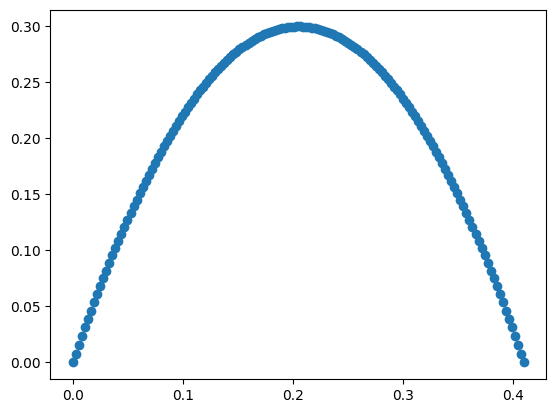

In [15]:
test = u_inlet_func(inlet)
plt.scatter(inlet[:,1],test)

In [16]:
#DATA
data  = Data_handler()
data['collocation points'] = sample_from_tensor(2000,sampled_points,0)
data['inlet'] = inlet
data['outlet'] = outlet
data['no_slip_walls'] = torch.cat([top_wall,bot_wall],dim = 0)
data['cylinder'] = cyl
data.set_to_device('cuda')
#PYTORCH SETUP
torch.manual_seed(1234)

net = MLP(2,3,128,6,activation='sin')

sampler = R3_sampler(sample_from_tensor)



RUNNING SDF ON
Epoch 0 :--:   Boundary Loss:  4.896E-01  Residual Loss:  3.976E-02  
Epoch 500 :--:   Boundary Loss:  1.943E-04  Residual Loss:  6.163E-04  
Epoch 1000 :--:   Boundary Loss:  9.900E-05  Residual Loss:  4.803E-04  
Epoch 1500 :--:   Boundary Loss:  8.025E-05  Residual Loss:  4.766E-04  
Epoch 2000 :--:   Boundary Loss:  8.256E-05  Residual Loss:  3.519E-04  
Epoch 2500 :--:   Boundary Loss:  6.746E-05  Residual Loss:  2.942E-04  
Epoch 3000 :--:   Boundary Loss:  5.152E-05  Residual Loss:  2.038E-04  
Epoch 3500 :--:   Boundary Loss:  7.823E-05  Residual Loss:  1.844E-04  
Epoch 4000 :--:   Boundary Loss:  5.838E-04  Residual Loss:  2.678E-04  
Epoch 4500 :--:   Boundary Loss:  1.884E-04  Residual Loss:  1.566E-04  
Epoch 5000 :--:   Boundary Loss:  4.731E-05  Residual Loss:  1.634E-04  
Epoch 5500 :--:   Boundary Loss:  8.552E-05  Residual Loss:  1.568E-04  
Epoch 6000 :--:   Boundary Loss:  4.466E-04  Residual Loss:  1.750E-04  
Epoch 6500 :--:   Boundary Loss:  1.535E

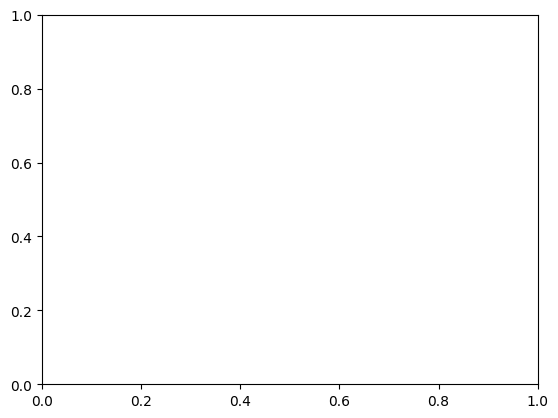

In [22]:

torch.manual_seed(1234)
net1 = Fourier_Net(2,3,50,4,RWF=True) 
torch.manual_seed(1234)
net2 = Fourier_Net(2,3,50,4,RWF=True)

xy = torch.meshgrid(torch.linspace(xmin,xmax,100),torch.linspace(ymin,ymax,100))
x = xy[0].flatten()
y = xy[1].flatten()
#Post Processing
plotter= Plotter(input_vars,output_vars)
plotter.set_contour_points(domain)

for net,ex in zip([net1,net2],['SDF OFF','SDF ON']):
    if ex =='SDF OFF':
        continue
    print(f'RUNNING {ex}')
    optimizer = torch.optim.Adam(params = net.parameters(), lr = 1e-3)
    LR_sch = StepLR(optimizer,10000,0.9)

    #SET UP DERIVATIVES
    PINN = DE_Getter(net)
    PINN.set_vars(input_vars,output_vars)
    PINN.set_derivatives(derivatives)
    # FD = FD_engine(net = net,derivatives= PINN.derivatives,dxs = [0.01,0.01],sdf= sdf)
    # PINN.set_deriv_method(FD)

    #LOSSES
    losses = Loss_handler(data.group_names())
    losses.add_boundary('inlet',{'u':u_inlet_func,
                                'v':0})

    # losses.add_boundary('outlet',{'u':u_inlet_func,
    #                             'v':0})


    losses.add_boundary('cylinder',{'u':0,
                                    'v':0 })

    losses.add_boundary('no_slip_walls',{'u':0,
                                        'v':0 })
    
    if ex == 'SDF ON': 
        losses.add_residual('collocation points',{'stokes_x':NS_x,
                                            'stokes_y':NS_y, 
                                            'incomp':incomp },weighting=sdf)

    else:
        losses.add_residual('collocation points',{'stokes_x':NS_x,
                                            'stokes_y':NS_y, 
                                            'incomp':incomp },weighting=1)

    
    net = net.cuda()
    torch.manual_seed(1234)
    for i in range(50_001):
        optimizer.zero_grad()
        data.set_to_device('cuda',to_show= False)
        output = PINN.calculate(data,target_group = 'collocation points')
        loss = losses.calculate(data,output)

        loss.sum().backward()
        optimizer.step()
        LR_sch.step()

        data['collocation points'] = sample_from_tensor(2000,sampled_points)

        if (i % 500) == 0:
            losses.print_losses(i)
            losses.log_loss()
        if (i % 5000) == 0:
            plotter.contour(net,['x','y'],'u',save_name=f'cyl/{ex}_u_epoch_{i}',epoch=i,show = False)

    